Import data.

In [0]:
import pandas as pd
import numpy as np
away_data = pd.read_csv('https://raw.githubusercontent.com/metrica-sports/sample-data/master/data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv', skiprows=2)
home_data = pd.read_csv('https://raw.githubusercontent.com/metrica-sports/sample-data/master/data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv', skiprows=2)

Reformat into lists indexed by player, e.g. `locs_home[0]` contains locations for player 0 on home team.

In [0]:
locs_home = [np.asarray(home_data.iloc[:,range(3 + j*2,3 + j*2 +2)]) * np.array([105,68]) for j in range(14)]
locs_away = [np.asarray(away_data.iloc[:,range(3 + j*2,3 + j*2 +2)]) * np.array([105,68]) for j in range(14)]
locs_ball = [np.asarray(home_data.iloc[:,range(31,33)]) * np.array([105,68])]
t = home_data['Time [s]']

In [0]:
np.all(np.isfinite(locs_home[0][24000:25000,:]))

True

Influence function as defined in appendix of the paper (I've tried to keep their notation as much as possible).

In [0]:
def influence_function(player_index, location, time_index, home_or_away):
  from scipy.stats import multivariate_normal as mvn
  if home_or_away == 'h':
    data = locs_home.copy()
  elif home_or_away == 'a':
    data = locs_away.copy()
  else:
    raise ValueError("Enter either 'h' or 'a'.")
    return
  if np.all(np.isfinite(data[player_index][[time_index,time_index + 1],:])) & np.all(np.isfinite(locs_ball[0][time_index,:])):
    jitter = 1e-10 ## to prevent identically zero covariance matrices when velocity is zero
    ## compute velocity by fwd difference
    s = np.linalg.norm(data[player_index][time_index + 1,:] - data[player_index][time_index,:] + jitter) / (t[time_index + 1] - t[time_index])
    ## velocities in x,y directions
    sxy = (data[player_index][time_index + 1,:] - data[player_index][time_index,:] + jitter) / (t[time_index + 1] - t[time_index])
    ## angle between velocity vector & x-axis
    theta = np.arccos(sxy[0] / np.linalg.norm(sxy))
    ## rotation matrix
    R = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    mu = data[player_index][time_index,:] + sxy * 0.5
    Srat = (s / 13) ** 2
    Ri = np.linalg.norm(locs_ball[0][time_index,:] - data[player_index][time_index,:])
    Ri = np.minimum(4 + Ri**3/ (18**3/6),10) ## don't think this function is specified in the paper but looks close enough to fig 9
    S = np.array([[(1 + Srat) * Ri / 2, 0], [0, (1 - Srat) * Ri / 2]])
    Sigma = np.matmul(R,S)
    Sigma = np.matmul(Sigma,S)
    Sigma = np.matmul(Sigma,np.linalg.inv(R)) ## this is not efficient, forgive me.
    out = mvn.pdf(location,mu,Sigma) / mvn.pdf(data[player_index][time_index,:],mu,Sigma)
  else:
    out = np.zeros(location.shape[0])
  return out

Here's a plot of the pitch control at the 24000th timepoint. 

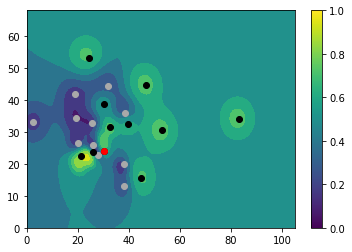

In [0]:
import matplotlib.pyplot as plt

xx,yy = np.meshgrid(np.linspace(0,105,200),np.linspace(0,68,200))
Zh = np.zeros(40000)
Za = np.zeros(40000)

for k in range(11):
  Zh += influence_function(k,np.c_[xx.flatten(),yy.flatten()],24000,'h')
  Za += influence_function(k,np.c_[xx.flatten(),yy.flatten()],24000,'a')
Zh = Zh.reshape((200,200))
Za = Za.reshape((200,200))
plt.contourf(xx,yy,1 / (1 + np.exp(-Za + Zh)))
for k in range(11):
  plt.scatter(locs_home[k][24000,0],locs_home[k][24000,1],color='darkgray')
  plt.scatter(locs_away[k][24000,0],locs_away[k][24000,1],color='black')
plt.scatter(locs_ball[0][24000,0],locs_ball[0][24000,1],color = 'red')
plt.colorbar()

And, for reference, the locations of the home players (grey), away players (black) & the ball (red). 

Seems sensible, I think, but quite possibly some mistakes on my end. Guess we'll see what Javi produces over next few days :)

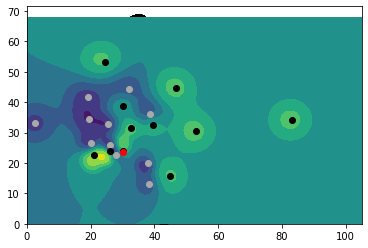

In [0]:
from IPython.display import HTML
import matplotlib.animation as animation

fig,ax = plt.subplots()
ims= []
xx,yy = np.meshgrid(np.linspace(0,105,200),np.linspace(0,68,200))

def animate(i):
  fr = 23000 + i
  Zh = np.zeros(40000)
  Za = np.zeros(40000)
  for k in range(11):
    Zh += influence_function(k,np.c_[xx.flatten(),yy.flatten()],fr,'h')
    Za += influence_function(k,np.c_[xx.flatten(),yy.flatten()],fr,'a')
  Zh = Zh.reshape((200,200))
  Za = Za.reshape((200,200))
  im = plt.contourf(xx,yy,1 / (1 + np.exp(-Za + Zh)))

  for k in range(11):
    plt.scatter(locs_home[k][fr,0],locs_home[k][fr,1],color='darkgray')
    plt.scatter(locs_away[k][fr,0],locs_away[k][fr,1],color='black')
  plt.scatter(locs_ball[0][fr,0],locs_ball[0][fr,1],color = 'red')

HTML(animation.FuncAnimation(fig, animate, frames=1000, interval = 40,repeat=False).to_html5_video())